In [ ]:
!pip install neuralforecast

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.8/141.8 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.6/58.6 MB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.0/719.0 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.5/468.5 kB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATSx
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss, MSE, MAE
from neuralforecast.tsdataset import TimeSeriesDataset, TimeSeriesLoader
from numpy.random import seed
from random import randrange
from neuralforecast.losses.numpy import rmse, mape
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
from neuralforecast.utils import AirPassengers, AirPassengersPanel, AirPassengersStatic

In [ ]:
df = pd.read_excel("Temperature in Sao Paulo.xlsx",index_col='Date',parse_dates=True, sheet_name="S&P 500")


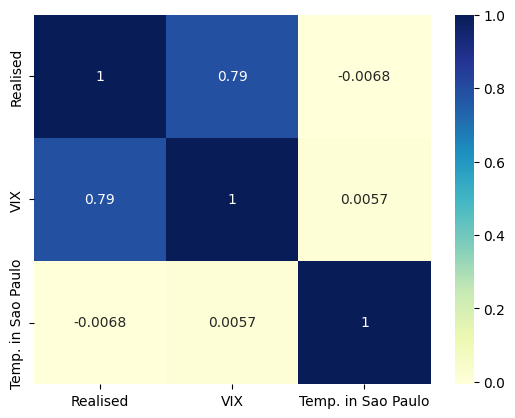

In [ ]:
import seaborn as sb
dataplot = sb.heatmap(df.corr(), cmap="YlGnBu", annot=True)
  
# displaying heatmap
plt.show()

In [ ]:
df = pd.read_excel("Temperature in Sao Paulo (NBEATSx).xlsx",index_col='Date',parse_dates=True, sheet_name="S&P 500")

In [ ]:
df.reset_index(inplace=True)
df.rename(columns={'Date':'ds'}, inplace=True)
df.rename(columns={'Realised':'y'}, inplace=True)
train = df.iloc[:int(len(df['y'])*0.7)]
test = df.iloc[int(len(df['y'])*0.7)]
validation_length=int(len(df['y'])*0.7)-int(len(df['y'])*0.6)

Epoch: 150 | Inputs: 63 | MLP units: [[250, 250], [250, 250]] | Loss: MSE() | Scaler Type: robust
Stack Types: ['trend', 'seasonality'] | Learning Rate: 0.0005

# H=1 Forecasts

In [ ]:
Accuracy=[]
RMSE=[]
Quasilikelihood=[]

In [ ]:
test_length=len(df["y"])-int(len(df['y'])*0.7)

In [ ]:
for i in range(13):
  model = NBEATSx(h=1, input_size=21,
                  loss=MQLoss(level=[90]),
                  scaler_type='minmax',
                  learning_rate= 0.0001,
                  stack_types=['identity','identity'],
                  n_blocks=[1,1],
                  mlp_units= [[512, 512], [512, 512]],
                  windows_batch_size=60,
                  num_lr_decays=5,
                  val_check_steps=100,
                  n_harmonics=0, n_polynomials=0,
                  hist_exog_list=['VIX','Temp. in Sao Paulo'],
                  max_steps=150,
                  early_stop_patience_steps=1,
                  random_seed=randrange(129228148)
                  )
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=df,val_size=10,static_df=AirPassengersStatic,n_windows=None, test_size=test_length,step_size=1)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE.append(np.sum(np.sqrt((Y_true-Y_hat)**2))/len(Y_true))
  Accuracy.append((1-np.sum(np.sqrt((Y_true-Y_hat)**2)/Y_true)/(len(Y_true)))*100)
  Quasilikelihood.append(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))

INFO:lightning_fabric.utilities.seed:Global seed set to 104463731


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 22068138


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 125681447


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 58823735


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 98207660


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 85282373


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 34544794


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 63502219


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 90857383


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 73799539


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 87134550


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 97085816


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 91221762


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

In [ ]:
Accuracy

[68.58897323429076,
 67.56088979595327,
 68.274037231599,
 69.20594367396895,
 68.70222278733216,
 66.68036332411592,
 67.8320523676944,
 68.49765912934707,
 68.13463927443273,
 69.3513679093793,
 67.7538402902548,
 68.94935971330068,
 68.0062030856847,
 68.19060831009526,
 68.10044450274724]

In [ ]:
RMSE

[0.0020276407811187715,
 0.002078635273943827,
 0.002030418242027521,
 0.0020203479274729296,
 0.0020348030758507983,
 0.0020692884547231344,
 0.0020393023705363965,
 0.002026771097422014,
 0.0020565082065813183,
 0.0020212404922091893,
 0.0020524631712263036,
 0.0020343252248697045,
 0.002038835991901058,
 0.0020363525302155004,
 0.0020379848321943755]

In [ ]:
Quasilikelihood

[0.07378433249351553,
 0.07768162995748354,
 0.07503853413331396,
 0.07560965761099057,
 0.0757146826809102,
 0.07506563319647612,
 0.07538886229968872,
 0.07586499501680957,
 0.07537240544741916,
 0.0756714121289626,
 0.07671094965703752,
 0.07841049645133744,
 0.07497784627624751,
 0.07481649344098035,
 0.07541949539288174]

Text(0, 0.5, 'S&P 500 Realized Volatility')

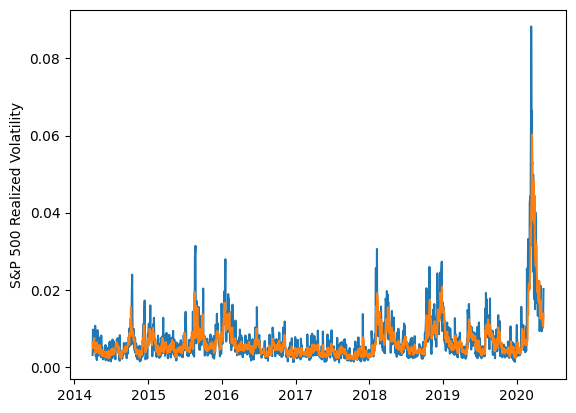

In [ ]:
plt.plot(forecasts["ds"], Y_true)
plt.plot(forecasts["ds"], Y_hat) 
plt.ylabel("S&P 500 Realized Volatility")

# H=3 Forecasts

In [ ]:
Accuracy=[]
RMSE=[]
Quasilikelihood=[]
test_length=len(df["y"])-int(len(df['y'])*0.7)

In [ ]:
for i in range(14):
  model = NBEATSx(h=3, input_size=21,
                  loss=MQLoss(level=[90]),
                  scaler_type='minmax',
                  learning_rate= 0.0001,
                  stack_types=['identity','identity'],
                  n_blocks=[1,1],
                  mlp_units= [[512, 512], [512, 512]],
                  windows_batch_size=60,
                  num_lr_decays=5,
                  val_check_steps=100,
                  n_harmonics=0, n_polynomials=0,
                  hist_exog_list=['VIX','Temp. in Sao Paulo'],
                  max_steps=150,
                  early_stop_patience_steps=1,
                  random_seed=randrange(129228148)
                  )
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=df,val_size=9,static_df=AirPassengersStatic,n_windows=None, test_size=test_length-1,step_size=3)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE.append(np.sum(np.sqrt((Y_true-Y_hat)**2))/len(Y_true))
  Accuracy.append((1-np.sum(np.sqrt((Y_true-Y_hat)**2)/Y_true)/(len(Y_true)))*100)
  Quasilikelihood.append(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))

INFO:lightning_fabric.utilities.seed:Global seed set to 72900851


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 27792637


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 36107935


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 784559


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 30990054


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 122560278


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 44266542


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 54844478


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 62381610


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 23574486


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 99741491


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 63023224


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 98500655


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 126006365


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

In [ ]:
RMSE

[0.002237018462559533,
 0.0022172130024710936,
 0.002289687041890069,
 0.0022380801367094614,
 0.002208694248586458,
 0.002210832658488672,
 0.002308654319897905,
 0.0022143225257686447,
 0.002225575453140169,
 0.0022531996700586366,
 0.0022240853127543374,
 0.0022511500002789825,
 0.0022413931139294014,
 0.002239327881148845,
 0.002259480926348636]

In [ ]:
Accuracy


[65.84667261119115,
 66.78501586476318,
 64.56314057077041,
 66.0996669641722,
 66.03044222017148,
 65.98705783880322,
 64.03598620282244,
 66.15318247613136,
 66.26462115480429,
 65.01784640927302,
 66.1779956269825,
 65.04819168671241,
 64.78740157358997,
 65.78829611382939,
 65.4256327396193]

In [ ]:
Quasilikelihood

[0.0923292128503,
 0.09504761898294492,
 0.09480581561359193,
 0.09427525257964697,
 0.09068673584436335,
 0.09059218331232319,
 0.0953529824520695,
 0.09097769520858114,
 0.09335077526859978,
 0.0923130436349393,
 0.09113262056878858,
 0.09121032804795068,
 0.08933491860043946,
 0.09396912477710659,
 0.09417555392075214]

Text(0, 0.5, 'S&P 500 Realized Volatility')

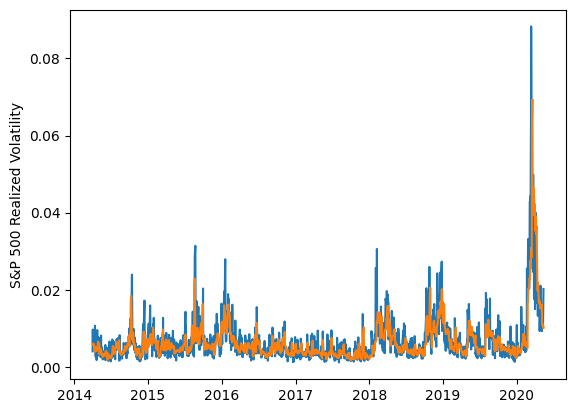

In [ ]:
plt.plot(forecasts["ds"], Y_true)
plt.plot(forecasts["ds"], Y_hat) 
plt.ylabel("S&P 500 Realized Volatility")

# H=5 Forecasts

In [ ]:
Accuracy=[]
RMSE=[]
Quasilikelihood=[]

In [ ]:
test_length%5

2

In [ ]:
for i in range(14):
  model = NBEATSx(h=5, input_size=21,
                  loss=MQLoss(level=[90]),
                  scaler_type='minmax',
                  learning_rate= 0.0001,
                  stack_types=['identity','identity'],
                  n_blocks=[1,1],
                  mlp_units= [[512, 512], [512, 512]],
                  windows_batch_size=60,
                  num_lr_decays=5,
                  val_check_steps=100,
                  n_harmonics=0, n_polynomials=0,
                  hist_exog_list=['VIX','Temp. in Sao Paulo'],
                  max_steps=150,
                  early_stop_patience_steps=1,
                  random_seed=randrange(129228148)
                  )
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=df,val_size=10,static_df=AirPassengersStatic,n_windows=None, test_size=test_length-2,step_size=5)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE.append(np.sum(np.sqrt((Y_true-Y_hat)**2))/len(Y_true))
  Accuracy.append((1-np.sum(np.sqrt((Y_true-Y_hat)**2)/Y_true)/(len(Y_true)))*100)
  Quasilikelihood.append(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))

INFO:lightning_fabric.utilities.seed:Global seed set to 11119403


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 113134330


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 42210334


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 27351393


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 85075820


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 35068740


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 90937328


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 67151856


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 121496633


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 71867664


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 3407793


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 11307507


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 16576806


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 88826767


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

In [ ]:
RMSE

[0.0024333147261817413,
 0.0023780473085511303,
 0.002415323581533488,
 0.0024189563023674244,
 0.002416104243844665,
 0.0024313158708840236,
 0.0023914220754157325,
 0.0024118680301683337,
 0.0024282557523831795,
 0.00242986569011834,
 0.002402274159299861,
 0.002416451840771252,
 0.0023951798545173942,
 0.002404730429362998,
 0.0024133863082559646]

In [ ]:
Accuracy

[63.110071227969186,
 63.919539543162784,
 63.62847864915048,
 63.335196517655355,
 62.93127657392397,
 62.53912004416753,
 64.21787406397254,
 63.391987911740244,
 63.03363008100469,
 62.50329846897347,
 63.338257526690114,
 62.734717863299196,
 63.55418025985367,
 64.13624767971217,
 63.44408700407873]

In [ ]:
Quasilikelihood

[0.11843537957559108,
 0.11408598362277472,
 0.11732208042976926,
 0.1157304825105336,
 0.11485742255372913,
 0.11566715848784173,
 0.11843071520355004,
 0.11584556014939416,
 0.11931282175157899,
 0.11361368820900984,
 0.1138896929624376,
 0.1122545913621926,
 0.11414569489997936,
 0.11797719577661947,
 0.11565536980320415]

Text(0, 0.5, 'S&P 500 Realized Volatility')

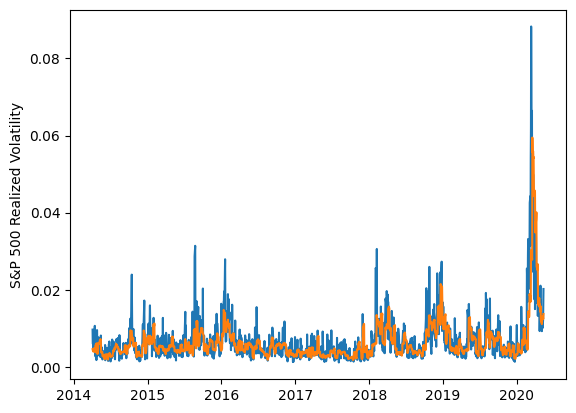

In [ ]:
plt.plot(forecasts["ds"], Y_true)
plt.plot(forecasts["ds"], Y_hat) 
plt.ylabel("S&P 500 Realized Volatility")

# H=10 Forecasts

In [ ]:
test_length%10

7

In [ ]:
Accuracy=[]
RMSE=[]
Quasilikelihood=[]

In [ ]:
for i in range(13):
  model = NBEATSx(h=10, input_size=21,
                  loss=MQLoss(level=[90]),
                  scaler_type='minmax',
                  learning_rate= 0.0001,
                  stack_types=['identity','identity'],
                  n_blocks=[1,1],
                  mlp_units= [[512, 512], [512, 512]],
                  windows_batch_size=60,
                  num_lr_decays=5,
                  val_check_steps=100,
                  n_harmonics=0, n_polynomials=0,
                  hist_exog_list=['VIX','Temp. in Sao Paulo'],
                  max_steps=150,
                  early_stop_patience_steps=1,
                  random_seed=randrange(129228148)
                  )
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=df,val_size=10,static_df=AirPassengersStatic,n_windows=None, test_size=test_length-7,step_size=10)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE.append(np.sum(np.sqrt((Y_true-Y_hat)**2))/len(Y_true))
  Accuracy.append((1-np.sum(np.sqrt((Y_true-Y_hat)**2)/Y_true)/(len(Y_true)))*100)
  Quasilikelihood.append(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))

INFO:lightning_fabric.utilities.seed:Global seed set to 76268473


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 94544014


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 42305376


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 20506051


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 110358595


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 40494101


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 28571659


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 40547473


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 117549067


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 99161161


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 37391579


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 101970981


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 44799487


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

In [ ]:
RMSE

[0.002911216327498411,
 0.002924574119593978,
 0.0029333686531368593,
 0.0029521490018577464,
 0.0029679633477706054,
 0.0029440341468640495,
 0.0029473829349577767,
 0.0029492518506397487,
 0.0029705349162958946,
 0.002937446851033522,
 0.002965665937028923,
 0.0029617025695747416,
 0.0029919811813276156,
 0.0029437619015150697,
 0.0029882892231308795]

In [ ]:
Accuracy

[54.56713284888157,
 54.123838758111106,
 53.75510055897315,
 53.54471807531136,
 53.01234704628567,
 53.90674958307091,
 53.42496666939041,
 53.885329773620796,
 53.03750629752464,
 53.96638887008767,
 53.71553483970873,
 53.50666472284065,
 52.81896372325989,
 53.1721108016366,
 53.13719050790351]

In [ ]:
Quasilikelihood

[0.1699131407549612,
 0.16044351281814856,
 0.1688026315327873,
 0.16910028173811228,
 0.16831650263902384,
 0.17350298969059175,
 0.16799584758156788,
 0.17767848730067237,
 0.16981846110657972,
 0.17220074396528462,
 0.17337229604765214,
 0.16960836307573415,
 0.16874680528411157,
 0.16372296034028574,
 0.17263916154426245]

Text(0, 0.5, 'S&P 500 Realized Volatility')

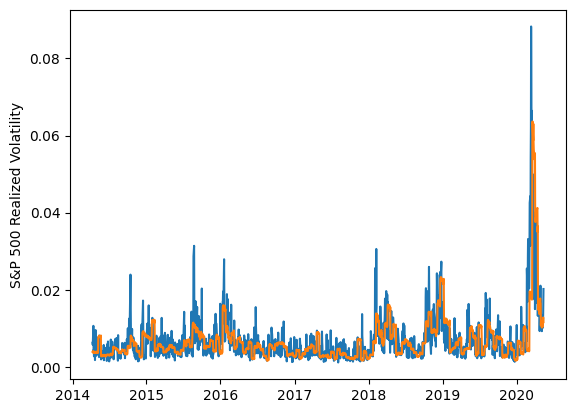

In [ ]:
plt.plot(forecasts["ds"], Y_true)
plt.plot(forecasts["ds"], Y_hat) 
plt.ylabel("S&P 500 Realized Volatility")

# H=22 Forecasts

In [ ]:
test_length%22

19

In [ ]:
Accuracy=[]
RMSE=[]
Quasilikelihood=[]

In [ ]:
for i in range(14):
  model = NBEATSx(h=22, input_size=21,
                  loss=MQLoss(level=[90]),
                  scaler_type='minmax',
                  learning_rate= 0.0001,
                  stack_types=['identity','identity'],
                  n_blocks=[1,1],
                  mlp_units= [[512, 512], [512, 512]],
                  windows_batch_size=60,
                  num_lr_decays=5,
                  val_check_steps=100,
                  n_harmonics=0, n_polynomials=0,
                  hist_exog_list=['VIX','Temp. in Sao Paulo'],
                  max_steps=150,
                  early_stop_patience_steps=1,
                  random_seed=randrange(129228148)
                  )
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=df,val_size=22,static_df=AirPassengersStatic,n_windows=None, test_size=test_length-19,step_size=22)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE.append(np.sum(np.sqrt((Y_true-Y_hat)**2))/len(Y_true))
  Accuracy.append((1-np.sum(np.sqrt((Y_true-Y_hat)**2)/Y_true)/(len(Y_true)))*100)
  Quasilikelihood.append(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))

INFO:lightning_fabric.utilities.seed:Global seed set to 82027806


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 110023569


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 34321210


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 93677924


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 57322247


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 36411709


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 95139058


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 5349511


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 5802077


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 47013460


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 83909099


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 44882214


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 58144397


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 100756713


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

In [ ]:
RMSE

[0.003706938052946938,
 0.0036354479100818445,
 0.003694409904064163,
 0.0036623692048180067,
 0.0036478267715993346,
 0.0036751223237222554,
 0.0036804981764231894,
 0.0036906904932034637,
 0.003698450363472625,
 0.003696091288606784,
 0.003654949507023944,
 0.003644978002262868,
 0.003637369638740514,
 0.003625556391376408,
 0.0036664768178417315]

In [ ]:
Accuracy

[38.28095461367656,
 39.21553393331387,
 38.45403994479511,
 38.861468138586815,
 39.08775903425994,
 38.705085017165,
 38.32428217087962,
 38.55273626981726,
 38.36215715233359,
 38.53683778416238,
 38.8782278520326,
 39.40048072413922,
 39.10698451107927,
 39.65939471539358,
 38.82250042715803]

In [ ]:
Quasilikelihood

[0.2475658442345698,
 0.2383207224278829,
 0.24775146544714013,
 0.23596861285667378,
 0.2370138449356049,
 0.24432409349780831,
 0.2342148335779239,
 0.2420311239464234,
 0.24182088750699732,
 0.24566764722172268,
 0.237659380190034,
 0.23875193188663096,
 0.2338551507965194,
 0.23754674901034864,
 0.23774678256586243]

Text(0, 0.5, 'S&P 500 Realized Volatility')

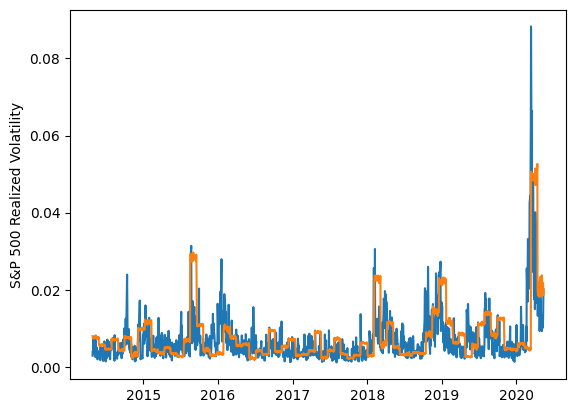

In [ ]:
plt.plot(forecasts["ds"], Y_true)
plt.plot(forecasts["ds"], Y_hat) 
plt.ylabel("S&P 500 Realized Volatility")